In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

In [9]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

In [3]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    #interface='ib0', # Interface to use
)

# Scale up
cluster.scale(5)

# Setup your client
client = Client(cluster)

/glade/work/linnia/conda-envs/mlenv/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34979 instead
  warnings.warn(


### Map to check

In [10]:
def plot_spatial_diagnostics(var_name, obs, default, tuned,
                              vmin=None, vmax=None, cmap='PRGn', savepath=None):

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.Robinson()})
    plt.rcParams['font.size'] = 16
    cropmask = xr.open_dataset(utils_path+'cropmask.nc')
    crop_mask = (cropmask.crop == 0)

    lf = xr.open_dataset(utils_path+'CLM-SP_amaxTLAI.nc').landfrac

    ## Panel 1: Observations
    ax = axes[0]
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    obs_data = obs * crop_mask.values
    pcm = ax.pcolormesh(obs.lon, obs.lat, obs_data, transform=ccrs.PlateCarree(),
                        shading='auto', cmap='Greens')
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title('Observed')

    ## Panel 2: Default - Obs
    ax = axes[1]
    model_default = get_map(default) * lf
    diff = (model_default - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff, transform=ccrs.PlateCarree(),
                        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title(f'Default - Observed\nRMSE = {rmse}')

    ## Panel 3: Tuned - Obs
    ax = axes[2]
    model_tuned = get_map(tuned) * lf
    diff = (model_tuned - obs) * crop_mask.values
    rmse = np.round(np.sqrt((diff ** 2).mean()).values, 3)
    ax.coastlines()
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '110m', facecolor='white'))
    pcm = ax.pcolormesh(obs.lon, obs.lat, diff, transform=ccrs.PlateCarree(),
                        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(pcm, ax=ax, fraction=0.08, orientation='horizontal')
    cbar.set_label(var_name)
    ax.set_title(f'Tuned - Observed\nRMSE = {rmse}')

    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=100)
    plt.show()


In [11]:
dvs = ['TOTVEGC','GPP','TLAI','EFLX_LH_TOT','ER','TOTSOMC_1m']

def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

In [12]:
# Load default
path = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_lhc/hist/*lhc0000*.h0.*'
files=sorted(glob.glob(path))
ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
# calculate 
lai_default = amax(ds_default['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
gpp_default = amean(ds_default['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
tvc_default = amean(ds_default['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')

In [13]:
# load test ensemble
base_path = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_'
#ensemble_ids = [f"caltest{str(i).zfill(4)}" for i in range(86, 91)]
ensemble_ids = ['cal115_c08132025']

all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h0.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds = xr.concat(all_datasets, dim='ens')

# calculate 
lai = amax(combined_ds['TLAI']).sel(year=slice('2001','2020')).mean(dim='year')
gpp = amean(combined_ds['GPP']).sel(year=slice('2001','2015')).mean(dim='year')
tvc = amean(combined_ds['TOTVEGC']).sel(year=slice('2000','2019')).mean(dim='year')

In [14]:
# check soil C 
la = xr.open_dataset('../../utils/sparsegrid_landarea.nc').landarea
soilc = gmean(amean(combined_ds['TOTSOMC_1m']).sel(year=2000),la)
soilc*1E-9*la.sum()

<xarray.DataArray (ens: 1)> Size: 8B
array([1694.54893021])
Coordinates:
  * ens      (ens) int64 8B 0
    year     int64 8B 2000

In [15]:
# load observations
obs = xr.open_dataset('observational_data.nc')

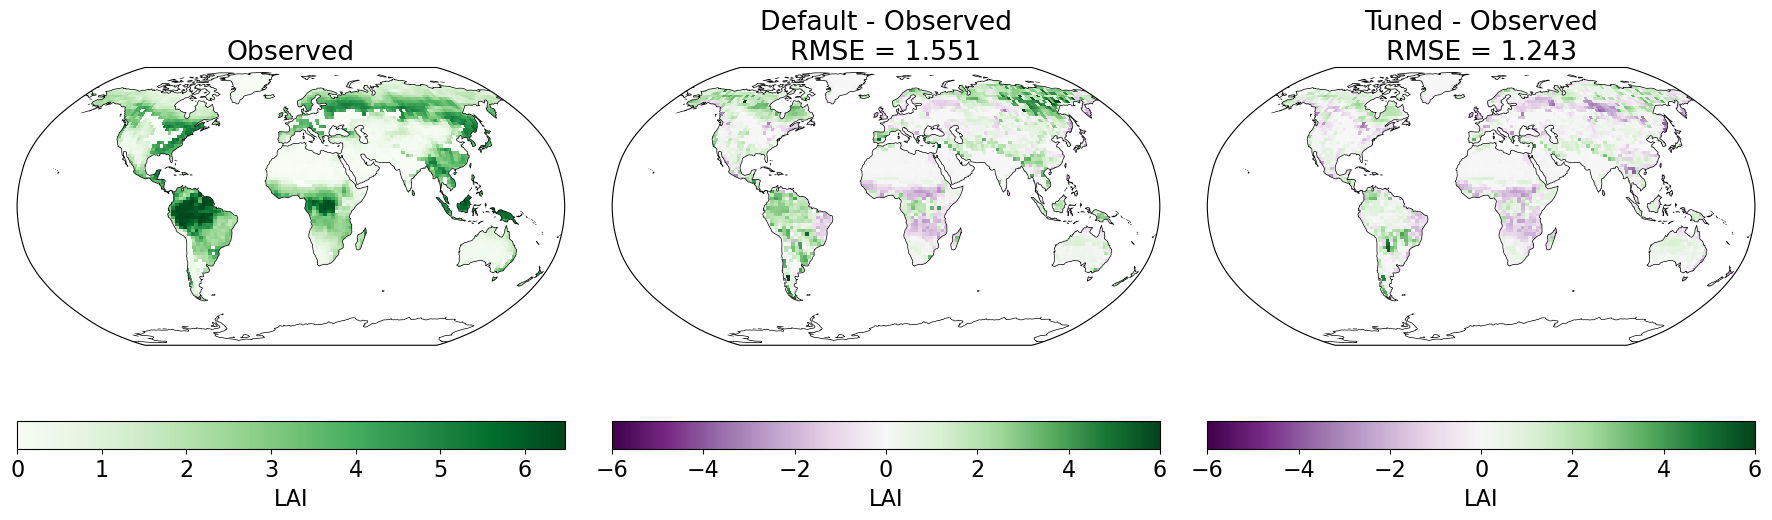

In [17]:
plot_spatial_diagnostics(
    var_name='LAI',
    obs=obs['LAI'],
    default=lai_default,
    tuned=lai.isel(ens=0),
    vmin=-6,
    vmax=6,
    cmap='PRGn',
    savepath='../figs/eval_sg_115_LAI.png'
)


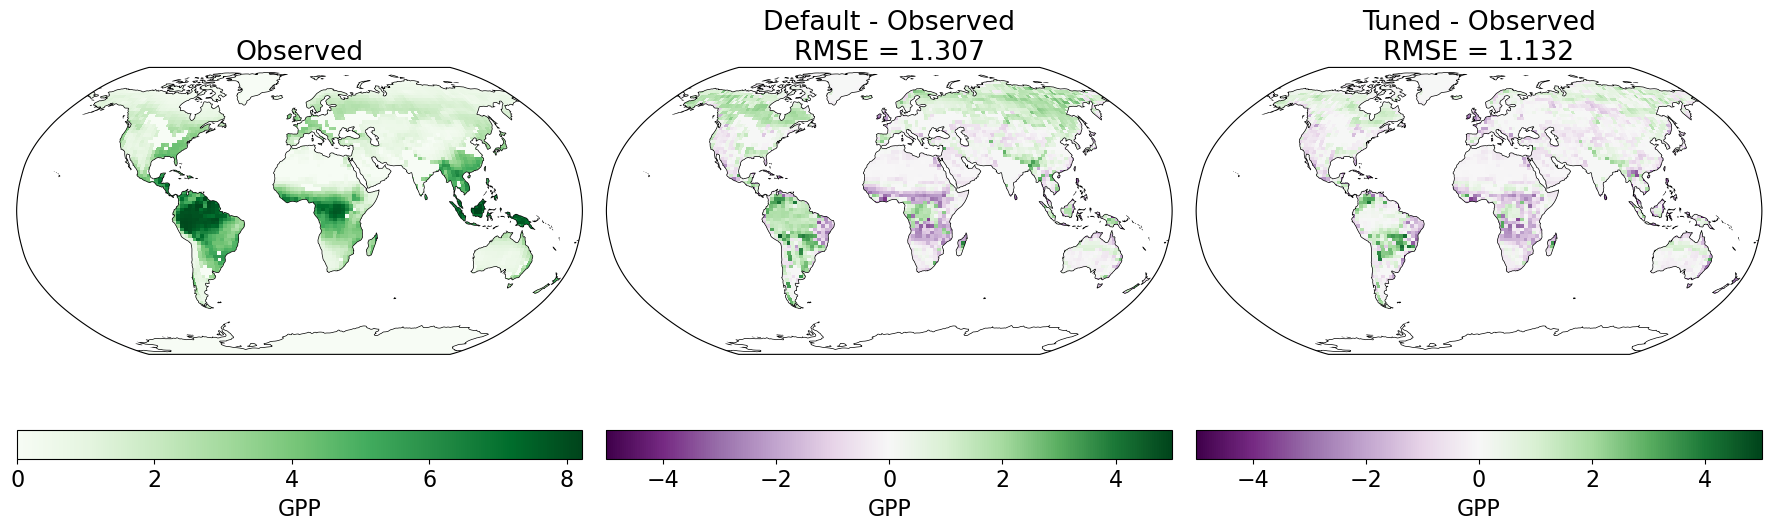

In [18]:
plot_spatial_diagnostics(
    var_name='GPP',
    obs=obs['GPP'],
    default=86400*gpp_default,
    tuned=86400*gpp.isel(ens=0),
    vmin=-5,
    vmax=5,
    cmap='PRGn',
    savepath='../figs/eval_sg_115_GPP.png'
)


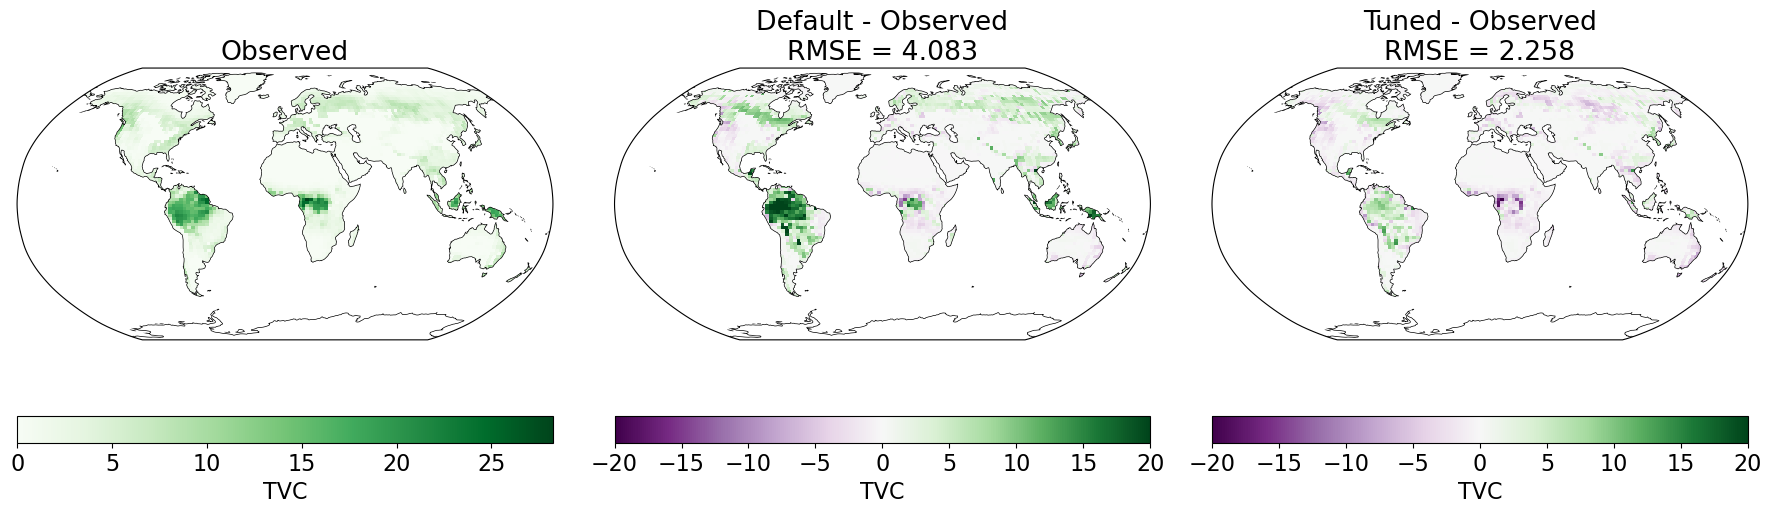

In [19]:
plot_spatial_diagnostics(
    var_name='TVC',
    obs=obs['TOTVEGC'],
    default=(1/1000)*tvc_default,
    tuned=(1/1000)*tvc.isel(ens=0),
    vmin=-20,
    vmax=20,
    cmap='PRGn',
    savepath='../figs/eval_sg_115_TVC.png'
)


### Emulator evaluation

In [22]:
# default
path = '/glade/campaign/cgd/tss/projects/PPE/ctsm6_lhc/hist/*lhc0000*.h1.*'
files=sorted(glob.glob(path))
ds_default = xr.open_mfdataset(files[28:],preprocess=pp).compute()
# calculate pxb mean
x=amax(ds_default['TLAI'].sel(time=slice('2001','2020'))).mean(dim='year')
TLAI_biome_amax_default = pxbmean(x)
TLAI_biome_amax_default = TLAI_biome_amax_default.sel(year=slice('2001','2020')).mean(dim='year')

x=amean(ds_default['GPP'].sel(time=slice('2001','2015'))).mean(dim='year')
GPP_biome_default = pxbmean(x)
GPP_biome_default = GPP_biome_default.sel(year=slice('2001','2015')).mean(dim='year')

x=amax(ds_default['TOTVEGC'].sel(time=slice('2000','2019'))).mean(dim='year')
TVC_biome_default = pxbmean(x)
TVC_biome_default = TVC_biome_default.sel(year=slice('2000','2019')).mean(dim='year')


In [20]:
# Load h1 tape
dvs = ['TLAI','GPP','TOTVEGC','pfts1d_itype_veg']
def pp(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds[dvs]

# load test ensemble
all_datasets = []

for ens_index, ens_id in enumerate(ensemble_ids):
    path = os.path.join(base_path + ens_id, 'run', '*.h1.*')
    files = sorted(glob.glob(path))
    
    if not files:
        print(f"No files found for ensemble {ens_id}")
        continue
    
    ds = xr.open_mfdataset(files[28:], preprocess=pp)
    ds = ds.expand_dims(ens=[ens_index])
    all_datasets.append(ds)

combined_ds_h1 = xr.concat(all_datasets, dim='ens')


In [21]:
#### calc biome means

yr1 = '2001'
yr2 = '2020'
v = 'TLAI'
TLAI_biome_amax = pxbmean(amax(combined_ds_h1[v].sel(time=slice(yr1,yr2))).mean(dim='year'))

yr1 = '2000'
yr2 = '2019'
tmp=(1/1000)*amean(combined_ds_h1['TOTVEGC'].sel(time=slice(yr1,yr2))).mean(dim='year')
TVC_biome = pxbmean(tmp) # kgC/m2

yr1 = '2001'
yr2 = '2015'
tmp=(60*60*24)*amean(combined_ds_h1['GPP'].sel(time=slice(yr1,yr2))).mean(dim='year')
GPP_biome = pxbmean(tmp) #gC/m2/day

In [24]:
# setup
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params_lhc = pd.read_csv(key).drop(columns='member')

pft_params   = ['kmax','psi50','jmaxb0','slatop','lmr_intercept_atkin',
                'medlynslope','medlynintercept','froot_leaf','leafcn','leaf_long',
                'KCN','dleaf','r_mort','fsr_pft','xl']
pftix=np.array([p in pft_params for p in params_lhc.columns])
u_params = params_lhc.columns[~pftix]

pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

import pickle
with open("../biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

biome_names = [biome_configs[i]['name'] for i in range(1,13)]

In [43]:
# load parameter sets

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('../default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]
default_params.loc[0, ['TAU']] = [0.7]
default_params.loc[0, ['RF_SS']] = [0.3]

default_params.loc[0,['leafcn_12']] = [0.9831]
default_params.loc[0,['slatop_12']] = [0.0315]

default_params.loc[0,['leafcn_11']] = [0.9984]
default_params.loc[0,['slatop_11']] = [0.0315]

default_params.loc[0,['KCN_14']] = [0]

In [59]:
# load paramset and create input X for emulators
cal115_paramset = default_params.copy()

cal_paramsets = xr.open_dataset('../../calibration/paramsets/caltest_97-102.nc')
#97-102: same as 91-96 but with corrected "write paramset" script. 
# cal115 = caltest94 and caltest100

for pft in pft_ids:
  for param in pft_params:
    cal115_paramset.loc[0,param+'_'+str(pft)] =  cal_paramsets[param].isel(ensemble=3,pft=pft).values

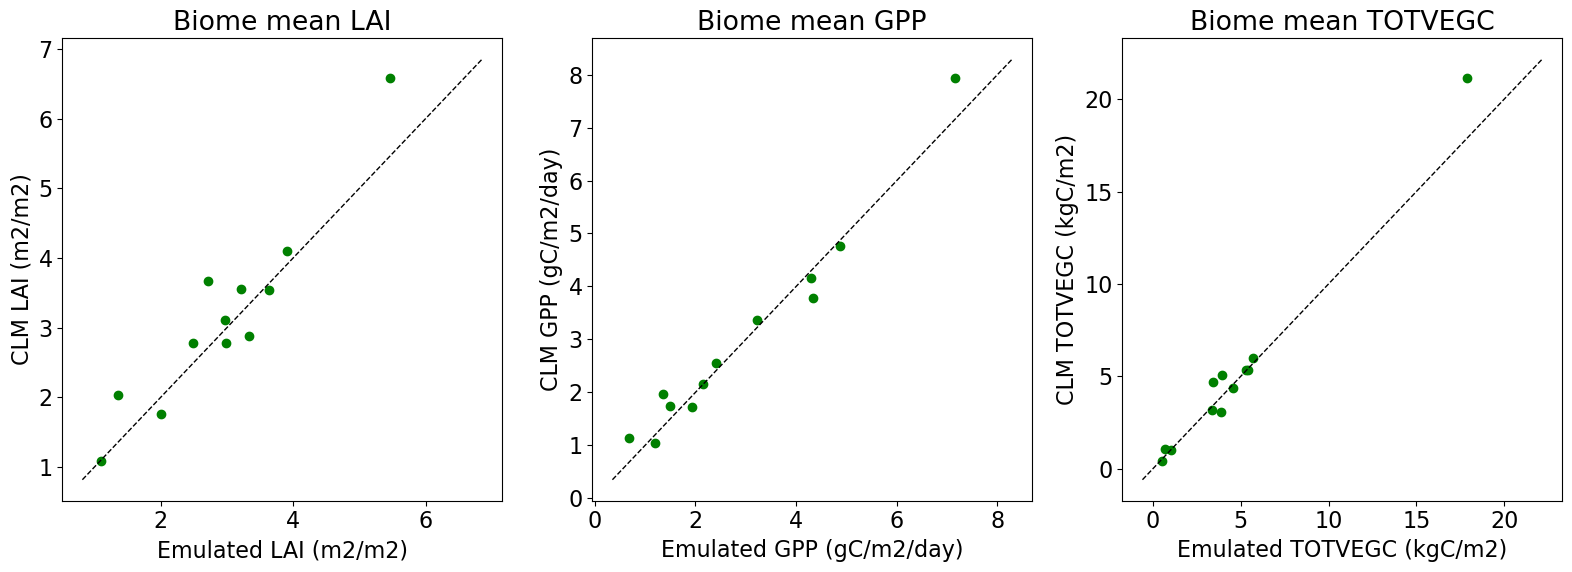

In [84]:
plt.figure(figsize=(16, 6))

# LAI
emulator_dir = '../emulators_biomelai_compiled/'
ax = plt.subplot(1, 3, 1)

for b, biome in enumerate(biome_names, start=1):

    y_cal = TLAI_biome_amax.sel(ens=0).isel(biome=b).mean(dim='year')

    pfts = biome_configs[b]['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols, param_names])
    
    samp = cal115_paramset[cols]
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp.values[0].reshape(1,-1))
    y_pred_vals = y_pred.numpy().flatten()

    ax.scatter(y_pred_vals,y_cal, color='green')

# Identity line on left axis
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
lims = [min(xmin, ymin), max(xmax, ymax)]
ax.plot(lims, lims, 'k--', linewidth=1)

ax.set_title('Biome mean LAI')
ax.set_ylabel('CLM LAI (m2/m2)')
ax.set_xlabel('Emulated LAI (m2/m2)')

# GPP
emulator_dir = '../emulators_biomegpp_compiled/'
ax = plt.subplot(1, 3, 2)

for b, biome in enumerate(biome_names, start=1):

    y_cal = GPP_biome.sel(ens=0).isel(biome=b).mean(dim='year')

    pfts = biome_configs[b]['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols, param_names])
    
    samp = cal115_paramset[cols]
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp.values[0].reshape(1,-1))
    y_pred_vals = y_pred.numpy().flatten()

    ax.scatter(y_pred_vals,y_cal, color='green')

# Identity line on left axis
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
lims = [min(xmin, ymin), max(xmax, ymax)]
ax.plot(lims, lims, 'k--', linewidth=1)

ax.set_title('Biome mean GPP')
ax.set_ylabel('CLM GPP (gC/m2/day)')
ax.set_xlabel('Emulated GPP (gC/m2/day)')

# TVC
emulator_dir = '../emulators_biomebiomass_compiled/'
ax = plt.subplot(1, 3, 3)

for b, biome in enumerate(biome_names, start=1):

    y_cal = TVC_biome.sel(ens=0).isel(biome=b).mean(dim='year')

    pfts = biome_configs[b]['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols, param_names])
    
    samp = cal115_paramset[cols]
    loaded_emulator = tf.saved_model.load(emulator_dir + biome)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp.values[0].reshape(1,-1))
    y_pred_vals = y_pred.numpy().flatten()

    ax.scatter(y_pred_vals,y_cal, color='green')

# Identity line on left axis
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
lims = [min(xmin, ymin), max(xmax, ymax)]
ax.plot(lims, lims, 'k--', linewidth=1)

ax.set_title('Biome mean TOTVEGC')
ax.set_ylabel('CLM TOTVEGC (kgC/m2)')
ax.set_xlabel('Emulated TOTVEGC (kgC/m2)')

plt.tight_layout()
plt.savefig('../figs/Emulator_eval_cal115_sparsegrid.png')